## Wczytanie bibliotek

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

## Wczytanie danych
Dane będą wczytywane z różnych plików, zostaną wczytane dane treningowe oraz testowe. Plik test data zawiera wszelkie cechy oprócz nazwy pokemona.

In [12]:
train_data = pd.read_csv("data/train_data.csv")
test_part1 = pd.read_csv("data/test_data.csv")
test_part2 = pd.read_csv("data/test_pokemon.csv")
test_data = pd.concat([test_part1, test_part2], axis=1)

In [15]:
train_data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,59,Arcanine,Fire,NaN,555,82,110,88,105,72,98,1,False
1,107,Hitmonchan,Fighting,NaN,455,47,97,84,27,121,79,1,False
2,123,Scyther,Bug,Flying,500,63,113,86,56,73,109,1,False
3,35,Clefairy,Fairy,NaN,323,67,54,46,58,62,36,1,False
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,97,193,102,157,98,133,1,True


In [48]:
test_data['Total'] = test_data['HP'] + test_data['Attack'] + test_data['Defense'] + test_data['Sp. Atk'] + test_data['Sp. Def'] + test_data['Speed']
test_data.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name,Total
0,Grass,Poison,79,103,119,123,116,85,1,False,VenusaurMega Venusaur,625
1,Fairy,NaN,69,35,53,63,64,39,1,False,Clefairy,323
2,Water,NaN,39,41,45,43,42,90,1,False,Poliwag,300
3,Normal,NaN,52,51,46,45,42,52,1,False,Ditto,288
4,Water,Fighting,89,93,98,80,87,63,1,False,Poliwrath,510


## Przetworzenie danych

### Usunięcie brakujących wartości

In [23]:
print("Brakujące wartości dla danych treningowych:")
print(train_data.isna().sum()) 

Brakujące wartości dla danych treningowych:
#                0
Name             0
Type 1           0
Type 2        1760
Total            0
HP               0
Attack           0
Defense          0
Sp. Atk          0
Sp. Def          0
Speed            0
Generation       0
Legendary        0
dtype: int64


In [24]:
print("Brakujące wartości dla danych testowych:")
print(test_data.isna().sum())

Brakujące wartości dla danych testowych:
Type 1           0
Type 2        1350
HP               0
Attack           0
Defense          0
Sp. Atk          0
Sp. Def          0
Speed            0
Generation       0
Legendary        0
Name             0
dtype: int64


In [25]:
train_notna_data = train_data.fillna("Other")
test_notna_data = test_data.fillna("Other")

In [28]:
print("Brakujące wartości dla danych treningowych:")
print(train_notna_data.isna().sum())

Brakujące wartości dla danych treningowych:
#             0
Name          0
Type 1        0
Type 2        0
Total         0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64


In [30]:
print("Brakujące wartości dla danych testowych:")
print(test_notna_data.isna().sum())

Brakujące wartości dla danych testowych:
Type 1        0
Type 2        0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
Name          0
dtype: int64


### Usunięcie niepoprawny wartości

In [31]:
train_clean = train_notna_data[(train_notna_data.HP > 0) & (train_notna_data.Attack > 0) & (train_notna_data.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(train_clean[train_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


In [33]:
test_clean = test_notna_data[(test_notna_data.HP > 0) & (test_notna_data.Attack > 0) & (test_notna_data.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(test_clean[test_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


### Normalizacja danych

In [36]:
def transform_dataset(data):
    data.Legendary = data.Legendary.astype(int)
    label_enc = LabelEncoder()
    minmax_scaler = MinMaxScaler()
    df_cat = pd.DataFrame()
    for column in ['Name', 'Type 1', 'Type 2']:
        df_cat[column] = label_enc.fit_transform(data[column])
    df_num = data[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
    columns = df_num.columns
    np_num = minmax_scaler.fit_transform(df_num)
    df_num_norm = pd.DataFrame(np_num, columns=columns)
    df_prepared = pd.concat([df_num_norm, df_cat, data['Generation']], axis=1)
    return df_prepared

train_df = transform_dataset(train_clean)
test_df = transform_dataset(test_clean)

In [39]:
train_df.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type 1,Type 2,Generation
0,0.615385,0.318898,0.550505,0.459893,0.507614,0.488189,0.603896,6,5,8,1
1,0.444444,0.181102,0.484848,0.438503,0.111675,0.874016,0.480519,60,4,8,1
2,0.521368,0.244094,0.565657,0.449198,0.258883,0.496063,0.675325,133,0,4,1
3,0.218803,0.259843,0.267677,0.235294,0.269036,0.409449,0.201299,23,3,8,1
4,1.000000,0.377953,0.969697,0.534759,0.771574,0.692913,0.831169,92,12,3,1


In [40]:
test_df.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type 1,Type 2,Generation
0,0.735043,0.307087,0.515152,0.623656,0.597990,0.820312,0.522293,154,7,9,1
1,0.218803,0.267717,0.171717,0.268817,0.296482,0.414062,0.229299,23,3,8,1
2,0.179487,0.149606,0.202020,0.225806,0.195980,0.242188,0.554140,118,14,8,1
3,0.158974,0.200787,0.252525,0.231183,0.206030,0.242188,0.312102,28,10,8,1
4,0.538462,0.346457,0.464646,0.510753,0.381910,0.593750,0.382166,120,14,3,1


## Regresja dla zmiennej Total

### Podział danych

In [132]:
scores_total = {}
X_train, y_train = train_df.drop('Total', axis=1), train_clean.Total
X_test, y_test = test_df.drop('Total', axis=1), test_clean.Total

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3308, 10) (3308,)
(2541, 10) (2541,)


### Regresja liniowa

In [133]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [134]:
y_pred = lin_reg.predict(X_test)
scores_total["lin_reg"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['lin_reg'][0]}")
print(f"R-squared: {scores_total['lin_reg'][1]}")

MSE: 2.0923
R-squared: 0.9998


### Regresja grzebietowa

In [128]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

Ridge()

In [135]:
y_pred = ridge_reg.predict(X_test)
scores_total["ridge"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['ridge'][0]}")
print(f"R-squared: {scores_total['ridge'][1]}")

MSE: 3.473
R-squared: 0.9997


### Lasso

In [136]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [138]:
y_pred = lasso_reg.predict(X_test)
scores_total["lasso"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total['lasso'][0]}")
print(f"R-squared: {scores_total['lasso'][1]}")

MSE: 174.0233
R-squared: 0.9867


### Regresja xgboost

In [139]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [140]:
y_pred = xgb_reg.predict(X_test)
scores_total["xgb"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_total["xgb"][0]}")
print(f"R-squared: {scores_total["xgb"][1]}")

MSE: 127.6226
R-squared: 0.9902


### Podsumowanie

In [146]:
df_total_scores = pd.DataFrame(scores_total)
df_total_scores.index = ['MSE', 'R-squared']
df_total_scores

,lin_reg,ridge,lasso,xgb
MSE,2.0923,3.4730,174.0233,127.6226
R-squared,0.9998,0.9997,0.9867,0.9902


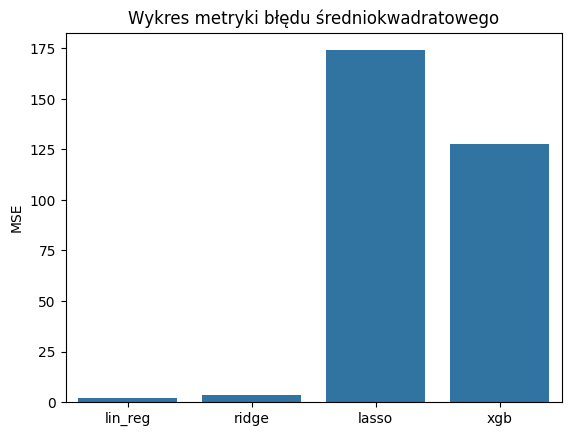

In [167]:
plt.title("Wykres metryki błędu średniokwadratowego")
sns.barplot(df_total_scores.loc['MSE'])
plt.show()

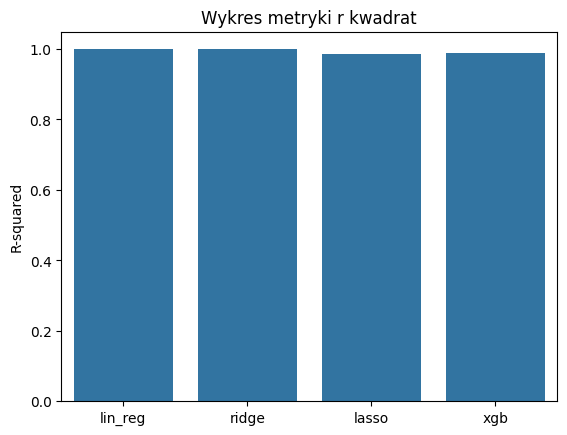

In [165]:
plt.title("Wykres metryki r kwadrat")
sns.barplot(df_total_scores.loc['R-squared'])
plt.show()

## Regresja dla zmiennej HP

### Podział danych

In [169]:
scores_hp = {}
X_train, y_train = train_df.drop('HP', axis=1), train_clean.HP
X_test, y_test = test_df.drop('HP', axis=1), test_clean.HP

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3308, 10) (3308,)
(2541, 10) (2541,)


### Regresja liniowa

In [170]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [171]:
y_pred = lin_reg.predict(X_test)
scores_hp["lin_reg"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp["lin_reg"][0]}")
print(f"R-squared: {scores_hp["lin_reg"][1]}")

MSE: 2.0923
R-squared: 0.9972


### Regresja grzbietowa

In [172]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

Ridge()

In [173]:
y_pred = ridge_reg.predict(X_test)
scores_hp["ridge"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp['ridge'][0]}")
print(f"R-squared: {scores_hp['ridge'][1]}")

MSE: 32.7919
R-squared: 0.9565


### Lasso

In [174]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

Lasso()

In [175]:
y_pred = lasso_reg.predict(X_test)
scores_hp["lasso"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp['lasso'][0]}")
print(f"R-squared: {scores_hp['lasso'][1]}")

MSE: 506.1958
R-squared: 0.3289


### Regresja xgboost

In [177]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [178]:
y_pred = xgb_reg.predict(X_test)
scores_hp["xgb"] = (np.round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4), np.round(r2_score(y_true=y_test, y_pred=y_pred),4))
print(f"MSE: {scores_hp["xgb"][0]}")
print(f"R-squared: {scores_hp["xgb"][1]}")

MSE: 27.2886
R-squared: 0.9638


### Podsumowanie

In [179]:
df_hp_scores = pd.DataFrame(scores_hp)
df_hp_scores.index = ['MSE', 'R-squared']
df_hp_scores

,lin_reg,ridge,lasso,xgb
MSE,2.0923,32.7919,506.1958,27.2886
R-squared,0.9972,0.9565,0.3289,0.9638


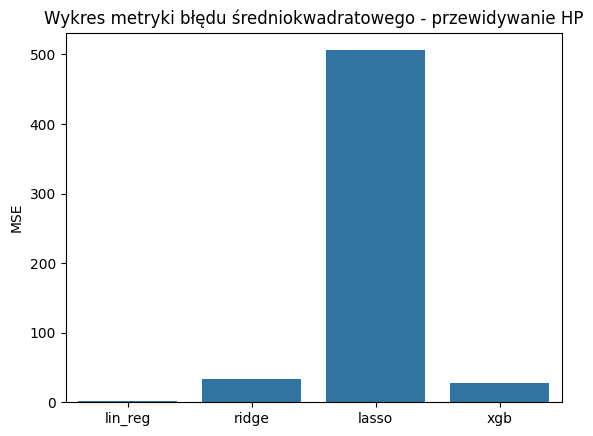

In [180]:
plt.title("Wykres metryki błędu średniokwadratowego - przewidywanie HP")
sns.barplot(df_hp_scores.loc['MSE'])
plt.show()

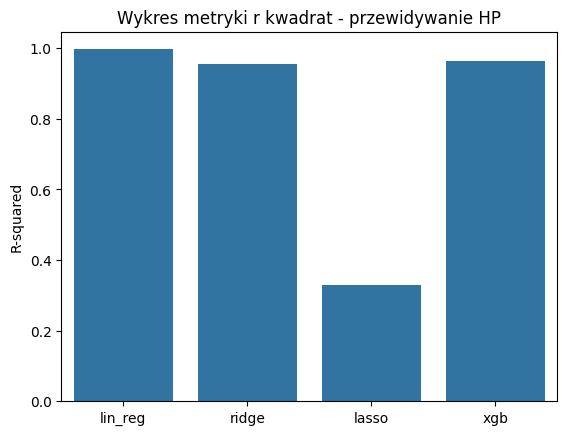

In [181]:
plt.title("Wykres metryki r kwadrat - przewidywanie HP")
sns.barplot(df_hp_scores.loc['R-squared'])
plt.show()